In [1]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
X_train = X_train.float()
X_test = X_test.float()

In [6]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

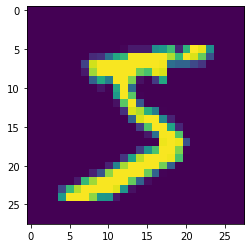

tensor(5)


In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [9]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [10]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons ,activation = 'sigmoid', n_layers = 3):
      super(MNISTNet, self).__init__()

      if activation == 'sigmoid':
          act = torch.nn.Sigmoid()
      elif activation == 'relu':
          act = torch.nn.ReLU()

      self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
      self.ac1 = act

      self.hidden_layers = torch.nn.Sequential()
      for i in range(n_layers):
          self.hidden_layers.add_module(f'hidden_{i}',torch.nn.Linear(n_hidden_neurons, n_hidden_neurons))
          self.hidden_layers.add_module(f'act_{i}',act)

      self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
      x = self.fc1(x)
      x = self.hidden_layers(x)
      x = self.fc2(x)
      return x

In [11]:
from time import time
def train(mnistnet, optimizer, X_train, y_train, X_test, y_test, device):
  loss = torch.nn.CrossEntropyLoss()
  batch_size = 100
  test_accuracy_history = []
  test_loss_history = []

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  start_time = time()
  for epoch in range(100):
      order = np.random.permutation(len(X_train))

      for start_index in range(0, len(X_train), batch_size):
          optimizer.zero_grad()

          batch_indexes = order[start_index:start_index+batch_size]

          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)

          preds = mnistnet.forward(X_batch) 

          loss_value = loss(preds, y_batch)
          loss_value.backward()

          optimizer.step()

      test_preds = mnistnet.forward(X_test)
      test_loss_history.append(loss(test_preds, y_test))

      accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
      test_accuracy_history.append(accuracy)
      if epoch % 20 == 0:
          print(accuracy)
  finish_time = time()
  print('working time = '+ str(finish_time - start_time))

Создадим нейросеть по заданным в варианте данным

1 задание (device = cuda:0)

In [12]:
device = torch.device('cuda:0')
mnist_net = MNISTNet(20).to(device)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
train(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

tensor(0.3460, device='cuda:0')
tensor(0.8450, device='cuda:0')
tensor(0.8879, device='cuda:0')
tensor(0.8949, device='cuda:0')
tensor(0.8942, device='cuda:0')
working time = 130.4632167816162


2 задание

In [13]:
for n in range(1,64,16):
  mnist_net = MNISTNet(n).to(device)
  optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
  batch_size = 10240
  print(f'n_hidden_neurons {n}')
  train(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

n_hidden_neurons 1
tensor(0.2091, device='cuda:0')
tensor(0.2476, device='cuda:0')
tensor(0.3050, device='cuda:0')
tensor(0.3391, device='cuda:0')
tensor(0.3821, device='cuda:0')
working time = 127.10010814666748
n_hidden_neurons 17
tensor(0.6139, device='cuda:0')
tensor(0.8764, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.8967, device='cuda:0')
tensor(0.8972, device='cuda:0')
working time = 127.05505156517029
n_hidden_neurons 33
tensor(0.7362, device='cuda:0')
tensor(0.9044, device='cuda:0')
tensor(0.9064, device='cuda:0')
tensor(0.9122, device='cuda:0')
tensor(0.9245, device='cuda:0')
working time = 134.26904463768005
n_hidden_neurons 49
tensor(0.7538, device='cuda:0')
tensor(0.8978, device='cuda:0')
tensor(0.9216, device='cuda:0')
tensor(0.9195, device='cuda:0')
tensor(0.9246, device='cuda:0')
working time = 135.4231493473053


Увеличение количества нейронов прямо влияет на точность предсказаний нейросети

In [14]:
mnist_net = MNISTNet(20,'sigmoid').to(device)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
print(f'activation type: sigmoid')
train(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

activation type: sigmoid
tensor(0.3175, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.8812, device='cuda:0')
tensor(0.9086, device='cuda:0')
tensor(0.9020, device='cuda:0')
working time = 127.172443151474


In [15]:
mnist_net = MNISTNet(20,'relu').to(device)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
print(f'activation type: relu')
train(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

activation type: relu
tensor(0.9260, device='cuda:0')
tensor(0.9587, device='cuda:0')
tensor(0.9594, device='cuda:0')
tensor(0.9577, device='cuda:0')
tensor(0.9596, device='cuda:0')
working time = 129.93052196502686


Изменение типа активации привело к увеличению точности предсказаний на 5%

In [16]:
for n in range(1,16,4):
  mnist_net = MNISTNet(20, 'sigmoid', n).to(device)
  optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
  print(f'hidden layers: {n}')
  train(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

hidden layers: 1
tensor(0.8540, device='cuda:0')
tensor(0.9090, device='cuda:0')
tensor(0.9112, device='cuda:0')
tensor(0.9109, device='cuda:0')
tensor(0.9175, device='cuda:0')
working time = 94.5099823474884
hidden layers: 5
tensor(0.2581, device='cuda:0')
tensor(0.7398, device='cuda:0')
tensor(0.7979, device='cuda:0')
tensor(0.8030, device='cuda:0')
tensor(0.8404, device='cuda:0')
working time = 161.09000444412231
hidden layers: 9
tensor(0.2105, device='cuda:0')
tensor(0.4219, device='cuda:0')
tensor(0.5552, device='cuda:0')
tensor(0.7155, device='cuda:0')
tensor(0.5763, device='cuda:0')
working time = 224.18694424629211
hidden layers: 13
tensor(0.1135, device='cuda:0')
tensor(0.1135, device='cuda:0')
tensor(0.1135, device='cuda:0')
tensor(0.1135, device='cuda:0')
tensor(0.1135, device='cuda:0')
working time = 287.4558138847351


Увеличение количества слоёв привело к уменьшению точности предсказаний (требуется увеличение количества эпох, чтобы увеличение количества слоёв привело к улучшению результатов предсказаний)

3 задание

In [17]:
device = torch.device('cpu')
mnist_net = MNISTNet(20).to(device)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
train(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

tensor(0.4919)
tensor(0.8861)
tensor(0.9027)
tensor(0.9019)
tensor(0.9084)
working time = 91.08329224586487


In [18]:
device = torch.device('cuda:0')
mnist_net = MNISTNet(20).to(device)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
train(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

tensor(0.5233, device='cuda:0')
tensor(0.8639, device='cuda:0')
tensor(0.8891, device='cuda:0')
tensor(0.9058, device='cuda:0')
tensor(0.9050, device='cuda:0')
working time = 127.36763334274292


Время обучения при переходе на GPU повысилось на 36 секунд

4 задание

Проверим переобучение, добавив метод с выводом потерь на график

In [23]:
def plotTrain(mnistnet, optimizer, X_train, y_train, X_test, y_test, device):
  loss = torch.nn.CrossEntropyLoss()
  batch_size = 100
  test_accuracy_history = []
  test_loss_history = []
  train_loss_history = []

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  start_time = time()
  for epoch in range(100):
    order = np.random.permutation(len(X_train))

    train_step_loss_history = []
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        train_step_loss_history.append(loss_value.item())

    train_loss_history.append(torch.mean(torch.Tensor(train_step_loss_history)).item())
    test_preds = mnist_net.forward(X_test)
    test_loss_value = loss(test_preds, y_test)
    test_loss_history.append(test_loss_value.item())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
  pd.DataFrame({'train': train_loss_history, 'test': test_loss_history}).plot()

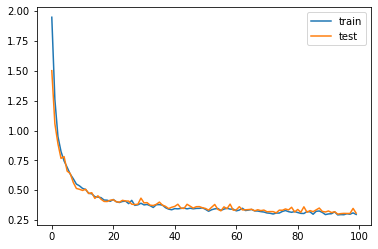

In [24]:
import matplotlib.pyplot as plt
device = torch.device('cuda:0')
mnist_net = MNISTNet(20).to(device)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)
plotTrain(mnist_net,optimizer,X_train,y_train,X_test,y_test, device) 

По графику можно увидеть, что переобучения нет (графики потерь кореллируют между собой)